In [2]:
#Imports
from time import time
import pandas as pd
pd.set_option("max.colwidth", 500)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD, NMF
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from textblob import TextBlob

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
path = "../data/NLP_data/ds_articles.csv"

#We're only be using the text and title columns
articles = pd.read_csv(path, usecols=["text", "title"], encoding="utf-8")

#Drop nulls
articles.dropna(inplace=True)

#Reset index
articles.reset_index(inplace=True, drop=True)

articles.head()

,text,title
0,One of the greatest difficulties that companies wishing to become more analytical have encountered over the last several years is finding good analysts and data scientists. A considerable amount of printer’s ink has been spilled into articles over this issue. Many of them mention consultants’ or analyst firms’ projections about how many quantitative analysts or data scientists will be needed in our society and conclude that it will be incredibly difficult to find them.\n\nI always thought th...,What Data Scientist Shortage? Get Serious and Get Talent
1,"Within soccer’s nascent analytics movement, one metric dominates most discussions. It’s called Expected Goals or xG. Models for calculating xG differ, but the underlying concept is the same. In a nutshell, xG takes a shot’s characteristics – distance from goal, angle from goal, root cause, etc. – and assigns a probability that said shot will result in a goal. Accounting for these probabilities reveals which team creates better scoring opportunities. Given a season of data, xG analysis is a p...","xG, Soccer Analytics of Bundesliga in R"
2,"The company’s adjacent market opportunities are growing at a CAGR of 18% for the next five years.\n\nQualcomm (NASDAQ: QCOM) announced a few days ago that its subsidiary Qualcomm Technologies will offer OEMs its first machine learning SDK for running their own neural network models on devices powered by Snapdragon 820 SoCs. The devices include smartphones, cars and drones among many others. Gary Brotman, director of product management, Qualcomm Technologies, said:\n\nWith the introduction of...",Qualcomm: Taking Artificial Intelligence To A New Level
3,"How Web, Tech Companies Use GPUs to Put Deep Learning at Your Fingertips\n\nGPUs have helped researchers spark a deep-learning revolution that’s given computers super-human capabilities.\n\nThey’ve already enabled breakthrough results on the industry-standard ImageNet benchmark. They’re powering Facebook’s “Big Sur” deep learning computing platform. They’re also accelerating major advances in deep learning across a broad range of fields.\n\nGPUs have become the go-to technology for training ...",How Companies Use GPUs to Put Deep Learning at Your Fingertips
4,"White House technology policy adviser Kristen Honey urged government and industry IT leaders to support the open data movement and showcase their work at two upcoming data innovation events.\n\nSpeaking Wednesday to a standing-room-only audience at the annual Data Innovation Summit in Washington, Honey highlighted a number of the administration’s open data initiatives, dating back to 2009, that are leading to innovative advances in medicine, agriculture, energy, transportation and education....",White House official urges IT leaders to join open data efforts


In [4]:
articles.shape

(1418, 2)

In [5]:
#Info
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418 entries, 0 to 1417
Data columns (total 2 columns):
text     1418 non-null object
title    1418 non-null object
dtypes: object(2)
memory usage: 22.2+ KB


tfidf is a score of words based on how many times it showed up & ranks them w/ a higher value. Therfore, lower score are stock or useless words.

In [7]:
CountVectorizer()

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Let's focus on the analyzer 'word', and turn it into a function!

In [9]:
# define a function that accepts text and returns a list of stems
def word_tokenize_stem(text):
    words = TextBlob(text).words
    stemmer = SnowballStemmer("english")
    
    return [stemmer.stem(word) for word in words]

# define a function that accepts text and returns a list of lemons (noun version)

def word_tokenize_lemma(text):
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

# define a function that accepts text and returns a list of lemons (verb version)
def word_tokenize_lemma_verb(text):
    words = TextBlob(text).words
    return [word.lemmatize(pos = "v") for word in words]

In [10]:
#Intialize tfidf with stop_words = english, max_features = 1000, and stem analzyer 

tfidf = TfidfVectorizer(stop_words="english", max_features=1000,
                        analyzer=word_tokenize_stem)

#Fit and transform the text using the tfidf vectorizer
text = articles.text
dtm = tfidf.fit_transform(text)

#Assign tokens to features
features = tfidf.get_feature_names()

In [11]:
#Create a dataframe of features and their idf scores
idfscores = pd.DataFrame()
idfscores["tokens"] = features
idfscores["scores"] = tfidf.idf_

In [13]:
idfscores.head()

,tokens,scores
0,'s,2.273771
1,0,3.632735
2,0.0,5.772801
3,1,2.193922
4,1.0,4.961871


In [12]:
#Top ten most imporant words
idfscores.sort_values(by = "scores", ascending = False).head(10)

,tokens,scores
999,⭐️,7.564560
937,var,6.311798
2,0.0,5.772801
4,1.0,4.961871
133,blockchain,4.594146
639,pdf,4.365887
625,p,4.345685
822,split,4.345685
422,https,4.197265
824,sql,4.146834


In [14]:
#Top ten least imporant words
idfscores.sort_values(by = "scores", ascending = True).head(10)

,tokens,scores
896,to,1.012766
875,the,1.015625
599,of,1.020649
20,a,1.024975
72,and,1.025697
438,in,1.033683
469,is,1.049848
355,for,1.049848
874,that,1.067786
977,with,1.070051


Let's our summarizer function that will randomly select an article to summarize. By summarize, I mean show the top five words with the highest tfidf values

In [15]:
def summarize():
    
    index = np.random.choice(articles.index, 1)[0]
    article = text.iloc[index]
    
    word_scores = {}
    for word in TextBlob(article).words:
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[index, features.index(word)]
    print "TOP SCORING WORD: "
    top_scores = sorted(word_scores.items(), key=lambda x:x[1], reverse = True)[:5]
    
    for word, score in top_scores:
        print word
        
    print "\n", articles.title[index]
    
    print "\n\n\n", article 

In [16]:
#Give it a go
summarize()

TOP SCORING WORD: 
to
the
market
and
algorithm

The modern marketer’s guide to machine learning algorithms



Most marketing (and sales) teams have seemingly simple goals: identify your best customers, target prospects who look like them, facilitate a positive buying experience, and bring these prospects into your customer community.

The challenge with this is that companies are faced with an onslaught of data, making it impossible to economically throw humans at each of the aforementioned objectives. Much business learning and many routine tasks can be done faster and better with automation and AI. People simply will never be able to sift through all that data at the same rate as machines, and certainly not with the precision that well-designed algorithms can bring to the table.

These days, every business is in the data business, and in order to make better decisions, leaders need machine learning and analytics to find actionable patterns in the data. But first, it’s important to cl

# Cosine Similarities (Distance)
Derive matrix of similarities between all the data science articles documents.

In [17]:
#Calculate cosine distance for each pair of documents
dist = cosine_similarity(dtm.toarray())

In [18]:
#make it a dataframe
dist_df = pd.DataFrame(dist)

#Shape
dist_df.shape

(1418, 1418)

In [19]:
dist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417
0,1.000000,0.511867,0.402506,0.406925,0.539928,0.588620,0.559592,0.394119,0.544926,0.695518,...,0.530374,0.528532,0.548809,0.623003,0.580267,0.474868,0.642727,0.412445,0.537975,0.461718
1,0.511867,1.000000,0.381670,0.324099,0.391966,0.472402,0.422089,0.284526,0.468988,0.428409,...,0.464231,0.442695,0.429140,0.441555,0.403916,0.394209,0.477249,0.311325,0.361777,0.316353
2,0.402506,0.381670,1.000000,0.332425,0.366210,0.446996,0.483040,0.347068,0.504429,0.404267,...,0.485108,0.380947,0.369834,0.368565,0.358955,0.339217,0.411618,0.386636,0.408286,0.302680
3,0.406925,0.324099,0.332425,1.000000,0.321691,0.526264,0.323191,0.324730,0.393705,0.325860,...,0.333350,0.412613,0.435853,0.361657,0.336451,0.323571,0.493398,0.299196,0.308887,0.267415
4,0.539928,0.391966,0.366210,0.321691,1.000000,0.461561,0.447141,0.382617,0.462106,0.524435,...,0.418841,0.420393,0.450688,0.449373,0.408160,0.418072,0.460504,0.350142,0.426743,0.357612


In [20]:
#Index position of a randomly selected article
index = 239

In [21]:
#Assign titles column to titles variable

titles = articles.title

#Print title
print titles[index]

#print article
print "\n ************************************************ \n" , text[index]


10 Popular TV Shows on Data Science and Artificial Intelligence

 ************************************************ 
Introduction

The development of full artificial intelligence could spell the end of human race. – Stephen Hawking

The world is now rapidly moving towards achieving this finest technology breakthrough ever. It is expected that AI would enrich humans with more power and opportunities. Another group of people (including Stephen Hawking and Elon Musk) believe that this might lead to human destruction (if not handled carefully).

I think, it’s too early for us to envisage such uncertain future. Good news is, companies like Google, Microsoft, Baidu have already started creating products based on AI. It won’t be long enough to experience the influence of AI in our daily lives.

Accidentally, my exploration of AI started with movie ‘Her’. The influence was so powerful that I ended up creating an infographic on 10 Movies on Data Science and Machine Learning. May be a ~ 2 hours m

We need to take the index value and use it grab the column of the scores between every article and the one at index 935

In [22]:
#Pass index value into dataframe
dist_column = dist_df[index]

In [25]:
#Get the index values of the 5 

closest_index = dist_column.nlargest(6).index[1:].tolist()

In [26]:
closest_index

[1130, 1000, 1220, 1009, 1076]

In [27]:
#Pass index values into titles and print them

for i in titles.iloc[closest_index].tolist():
    print i

Why algorithms will be at the core of our AI-powered future, and why you should care
Why We Need More Women Taking Part In The AI Revolution
How AI Is Already Changing Business
The Non-Technical Guide to Machine Learning & Artificial Intelligence
Will a machine replace me?


In [28]:
#Pass index values into titles and but don't print
text.iloc[closest_index]

1130    For the second year in a row, We Are Social had the privilege of presenting at Vivid Sydney this year. Already one of the world’s leading festivals, Vivid is a bit like SXSW: an amalgam of inspiring people, creative work, and fresh ideas across a variety of themes and topics.\n\nFor our 2017 keynote, I joined forces with We Are Social’s Sydney MD, Suzie Shaw, to explore the impact that algorithms and machine learning are having on every aspect of our lives, and what that means for marketing....
1000    Lolita Taub\n\nBy Samantha Walravens & Heather Cabot\n\nIn 2011, entrepreneur and investor Marc Andreessen wrote his famous ,"Why Software Is Eating the World" in the Wall Street Journal. Today, that story would more likely read, "Why Artificial Intelligence Is Eating the World." The market for artificial intelligence (AI) technologies-- from voice and image recognition to chat bots to self-driving cars-- is hot. A Narrative Science survey found last year that 38% of enterprises 

# Clustering
We will cluster using tfidf instead of count vectorizer to cluster the data

In [29]:
km = KMeans(n_clusters= 4)

#Fit algorithm
km.fit(dtm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [30]:
#Check out silhouette score
silhouette_score(dtm, km.labels_)

0.014575156917312357

In [31]:
#Assign labels to articles dataframe in a new column called "cluster".
articles["cluster"] = km.labels_

In [32]:
articles.head()

,text,title,cluster
0,One of the greatest difficulties that companies wishing to become more analytical have encountered over the last several years is finding good analysts and data scientists. A considerable amount of printer’s ink has been spilled into articles over this issue. Many of them mention consultants’ or analyst firms’ projections about how many quantitative analysts or data scientists will be needed in our society and conclude that it will be incredibly difficult to find them.\n\nI always thought th...,What Data Scientist Shortage? Get Serious and Get Talent,1
1,"Within soccer’s nascent analytics movement, one metric dominates most discussions. It’s called Expected Goals or xG. Models for calculating xG differ, but the underlying concept is the same. In a nutshell, xG takes a shot’s characteristics – distance from goal, angle from goal, root cause, etc. – and assigns a probability that said shot will result in a goal. Accounting for these probabilities reveals which team creates better scoring opportunities. Given a season of data, xG analysis is a p...","xG, Soccer Analytics of Bundesliga in R",2
2,"The company’s adjacent market opportunities are growing at a CAGR of 18% for the next five years.\n\nQualcomm (NASDAQ: QCOM) announced a few days ago that its subsidiary Qualcomm Technologies will offer OEMs its first machine learning SDK for running their own neural network models on devices powered by Snapdragon 820 SoCs. The devices include smartphones, cars and drones among many others. Gary Brotman, director of product management, Qualcomm Technologies, said:\n\nWith the introduction of...",Qualcomm: Taking Artificial Intelligence To A New Level,0
3,"How Web, Tech Companies Use GPUs to Put Deep Learning at Your Fingertips\n\nGPUs have helped researchers spark a deep-learning revolution that’s given computers super-human capabilities.\n\nThey’ve already enabled breakthrough results on the industry-standard ImageNet benchmark. They’re powering Facebook’s “Big Sur” deep learning computing platform. They’re also accelerating major advances in deep learning across a broad range of fields.\n\nGPUs have become the go-to technology for training ...",How Companies Use GPUs to Put Deep Learning at Your Fingertips,2
4,"White House technology policy adviser Kristen Honey urged government and industry IT leaders to support the open data movement and showcase their work at two upcoming data innovation events.\n\nSpeaking Wednesday to a standing-room-only audience at the annual Data Innovation Summit in Washington, Honey highlighted a number of the administration’s open data initiatives, dating back to 2009, that are leading to innovative advances in medicine, agriculture, energy, transportation and education....",White House official urges IT leaders to join open data efforts,1


In [34]:
articles.cluster.value_counts()

2    537
0    436
1    242
3    203
Name: cluster, dtype: int64

Print a sample of headlines/titles of articles within each cluster. We see that Cluster #2 is the largest group

In [33]:
#Cluster 0
for i in articles[articles.cluster == 0].sample(n = 10).title.tolist():
    print i

Advances in AI and ML are reshaping healthcare
Drones and phones are the next frontier for AI breakthroughs
Robots: Lifesavers or Terminators?
Artificial intelligence to take over half of all jobs in next decade – China’s top techie
How Machine Learning Facilitates Fraud Detection?
50 Companies Leading The AI Revolution, Detailed
Former Microsoft veteran Qi Lu opens up about AI, how Amazon beat Microsoft
5 machine learning trends that will define 2017
8 Companies Changing How Machine Learning Is Used
Machine Learning For Cybersecurity Not Cybercrime


In [35]:
#Cluster 1
for i in articles[articles.cluster == 1].sample(n = 10).title.tolist():
    print i

MapR to help admins peer into dense Hadoop clusters
MassMutual to invest $500k in University of Vermont for data science
The Science of Prediction
5 EBooks to Read Before Getting into A Data Science or Big Data Career
How data science fights modern insider threats
How Big Data can help make better life-critical decisions
Six (Mega)Trends for Deriving Massive Value From Big Data
4 reasons bots won’t replace data scientists anytime soon
Big data 2020: the future, growth and challenges of the big data industry
Meet the 11 Big Data & Data Science Leaders on LinkedIn


In [36]:
#Cluster 2
for i in articles[articles.cluster == 2].sample(n = 10).title.tolist():
    print i

Amazon Has Developed an AI Fashion Designer
What Is Machine Learning?
A machine-learning approach to venture capital
Netflix to open source orchestration framework
Twisted Light Could Dramatically Boost Data Rates
Cheat Sheet: 5 Things Everyone Should Know About Machine Learning
Travel Industry News & Conferences - EyeforTravel testing
Google boss on life beyond the smartphone and how the company will pay more tax in the UK
The Women Changing The Face Of AI
Human-Centered Design for Machine Learning


In [37]:
#Cluster 3
for i in articles[articles.cluster == 3].sample(n = 10).title.tolist():
    print i

Unsupervised Machine Learning for Beginners, Part 4: Apriori
Apple launches online journal for engineers to share their machine learning research
Deploying deep learning models with Docker and Kubernetes
10 Must Watch Movies on Data Science and Machine Learning
Machine learning - Neural network classification tutorial
Blogger
Hacker's guide to Neural Networks
System supporting money laundering detection
Who started the information age?
Apple Publishes Its First Artificial Intelligence Paper


We can see that the clusters are barely beating the eye test since they are so vaguely similar in the way they read. Since this is difficult to interpret, we will try this exercise again - but this time we'll cluster the cosine distances.

In [38]:
#Intialize clustering algorithm with 4 clusters
km2 = KMeans(n_clusters= 4)


#fit it on dist array
km2.fit(dist)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [39]:
#Check out silhouette score
silhouette_score(dist, km2.labels_)

0.28199394634494024

In [40]:
#Assign new labels to data frame

articles["cluster_dist"] = km2.labels_
articles.head()

,text,title,cluster,cluster_dist
0,One of the greatest difficulties that companies wishing to become more analytical have encountered over the last several years is finding good analysts and data scientists. A considerable amount of printer’s ink has been spilled into articles over this issue. Many of them mention consultants’ or analyst firms’ projections about how many quantitative analysts or data scientists will be needed in our society and conclude that it will be incredibly difficult to find them.\n\nI always thought th...,What Data Scientist Shortage? Get Serious and Get Talent,1,2
1,"Within soccer’s nascent analytics movement, one metric dominates most discussions. It’s called Expected Goals or xG. Models for calculating xG differ, but the underlying concept is the same. In a nutshell, xG takes a shot’s characteristics – distance from goal, angle from goal, root cause, etc. – and assigns a probability that said shot will result in a goal. Accounting for these probabilities reveals which team creates better scoring opportunities. Given a season of data, xG analysis is a p...","xG, Soccer Analytics of Bundesliga in R",2,1
2,"The company’s adjacent market opportunities are growing at a CAGR of 18% for the next five years.\n\nQualcomm (NASDAQ: QCOM) announced a few days ago that its subsidiary Qualcomm Technologies will offer OEMs its first machine learning SDK for running their own neural network models on devices powered by Snapdragon 820 SoCs. The devices include smartphones, cars and drones among many others. Gary Brotman, director of product management, Qualcomm Technologies, said:\n\nWith the introduction of...",Qualcomm: Taking Artificial Intelligence To A New Level,0,1
3,"How Web, Tech Companies Use GPUs to Put Deep Learning at Your Fingertips\n\nGPUs have helped researchers spark a deep-learning revolution that’s given computers super-human capabilities.\n\nThey’ve already enabled breakthrough results on the industry-standard ImageNet benchmark. They’re powering Facebook’s “Big Sur” deep learning computing platform. They’re also accelerating major advances in deep learning across a broad range of fields.\n\nGPUs have become the go-to technology for training ...",How Companies Use GPUs to Put Deep Learning at Your Fingertips,2,1
4,"White House technology policy adviser Kristen Honey urged government and industry IT leaders to support the open data movement and showcase their work at two upcoming data innovation events.\n\nSpeaking Wednesday to a standing-room-only audience at the annual Data Innovation Summit in Washington, Honey highlighted a number of the administration’s open data initiatives, dating back to 2009, that are leading to innovative advances in medicine, agriculture, energy, transportation and education....",White House official urges IT leaders to join open data efforts,1,1


In [41]:
articles.cluster_dist.value_counts()

2    572
1    538
0    246
3     62
Name: cluster_dist, dtype: int64

Cluster #2 is still the largest group, and we are seeing a much better sillouette score of .28, which is significantly greater than our previous cluster exercise.

In [44]:
#Cluster 0
for i in articles[articles.cluster_dist == 0].sample(n = 10).title.tolist():
    print i

AI for call centres proved successful with Genii AI solutions.
Use More Iterators
Top 20 Recent Research Papers on Machine Learning and Deep Learning
Here’s What Happened When Computers Tried Naming Metal Bands
10 Must Watch Movies on Data Science and Machine Learning
Tomorrow’s Business Leaders Learn How to Work with A.I.
The Machine Learning Imperative
Top 50 ggplot2 Visualizations - The Master List (With Full R Code)
Pushing the Boundaries of Predictive Analytics and the IoT
A Mechanism for Reliable Mobility Management for Internet of Things Using CoAP


In [45]:
#Cluster 1
for i in articles[articles.cluster_dist == 1].sample(n = 10).title.tolist():
    print i

5 Ways to Think of the Economic Impact of AI and Automation
Machine Intelligence: Revolutionizing Marketing
10 Real World Applications of Internet of Things (IoT) – Explained in Videos
Here is a New Resource for Your Organization and it’s called Big Data!
Training Machine Learning for Cyberthreats
Support Vector Machines: A Concise Technical Overview
How Machine-Learning AI Is Going To Make Your Phone Even Smarter
How Google uses machine learning in its search algorithms
Middle East & North Africa
How cognitive computing transforms the employee experience


In [46]:
#Cluster 2
for i in articles[articles.cluster_dist == 2].sample(n = 10).title.tolist():
    print i

The 10 Algorithms Machine Learning Engineers Need to Know
Top 9 ethical issues in artificial intelligence
Machine-learning earthquake prediction in lab shows promise
After trying to build self-driving tractors for more than 20 years, John Deere has learned a hard truth about autonomy
Using data science to beat cancer
Biden unveils launch of major, open-access database to advance cancer research
Move over silicon: Machine learning boom means we need new chips
Cheat Sheet: 5 Things Everyone Should Know About Machine Learning
Bayesian machine learning
Why machine learning will decide which IoT ‘things’ survive


In [50]:
#Cluster 3
for i in articles[articles.cluster_dist == 3].sample(n = 10).title.tolist():
    print i

Machine Learning Is The New Proving Ground For Competitive Advantage
Subscribe to read
Using Machine Learning and Big Data Analytics to Improve Existing Business Systems
Blogger
How can we address real concerns over artificial intelligence?
Subscribe to read
Deploying deep learning models with Docker and Kubernetes
Machine learning in our daily lives
Predicting Loan Credit Risk using Apache Spark Machine Learning Random Forests
Cheat Sheet of Machine Learning and Python (and Math) Cheat Sheets


In [57]:
km2.inertia_

5779.8921428599115

The Elbow Method is used to see the number of clusters (k) that optimizes our inertia score. 4 is the number of clusters that we have arbitrarily chosen, and we see that the breaking point of the "elbow" is also at 4 with this chart below. 

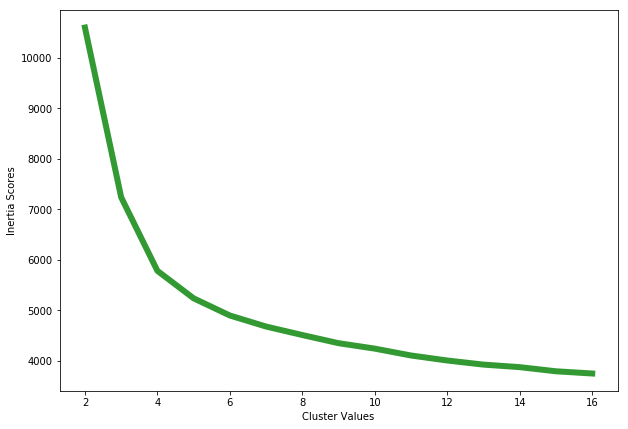

In [59]:
#Intialize range of cluster values from 2 to 16
cluster_range = range(2, 17)

#Intialize list to store inertia scores

i_scores = []

#Iterate over cluster range, fit models and add score to s_scores

for cluster in cluster_range:
    model = KMeans(n_clusters=cluster)
    model.fit(dist)
    
    score = model.inertia_
    i_scores.append(score)
    
#Plot clusters versus scores

plt.figure(figsize=(10, 7))
plt.plot(cluster_range, i_scores, linewidth = 6, alpha = .8, c = "g")
plt.xlabel("Cluster Values")
plt.ylabel("Inertia Scores");

Text Clustering is made possible once the text was converted to numerical data using both TF-IDF, & cosine similarities. K-Means was then applied to the numerical features to predict which class these articles belong to based on similarities. 